## Настройки/Гиперпараметры/Импорты

In [1]:
import pandas as pd
import numpy as np
import re
import psutil
from pandarallel import pandarallel
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn import metrics 

In [2]:
print('Количество доступных потоков: ', psutil.cpu_count(logical=False))

Количество доступных потоков:  4


### 1) Очистка данных

In [3]:
data = pd.read_excel("financial-news-sentiment.xlsx", usecols=[0,1])
data

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,Bearish
1,$CCL $RCL - Nomura points to bookings weakness...,Bearish
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",Bearish
3,$ESS: BTIG Research cuts to Neutral https://t....,Bearish
4,$FNKO - Funko slides after Piper Jaffray PT cu...,Bearish
...,...,...
12419,Stocks making the biggest moves midday: TD Ame...,Neutral
12420,Stocks making the biggest moves premarket: Fit...,Neutral
12421,Stocks making the biggest moves premarket: Hom...,Neutral
12422,Stocks making the biggest moves premarket: TD ...,Neutral


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12424 entries, 0 to 12423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    12278 non-null  object
 1   label   11934 non-null  object
dtypes: object(2)
memory usage: 194.2+ KB


In [5]:
data = data[data["label"].notnull()]
data = data[data["text"].notnull()]

In [6]:
data.describe()

,text,label
count,11934,11934
unique,11934,20
top,Edited Transcript of MSG earnings conference c...,Neutral
freq,1,7732


In [7]:
data["label"].value_counts()

Neutral                                                                                7732
Bullish                                                                                2397
Bearish                                                                                1788
 I am off... https://t.co/uiJBearishiHFoUw"                                               1
вЂ¦ https://t.co/tW98HHQBearishhb"                                                        1
 Nasdaq VP and Head of Capital Markets                                                    1
 well                                                                                     1
 in all likelihood                                                                        1
 multifunвЂ¦ https://t.co/L4lHjDTMXc"                                                     1
 cashless self-order kiosks are leaving outвЂ¦ https://t.co/eDBearishY4vGNeutral5W"       1
 theyвЂ™re finallyвЂ¦ https://t.co/sVmzdrN4ho"                                  

In [8]:
data = data[data["label"].isin(["Neutral", "Bullish", "Bearish"])]

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11917 entries, 0 to 12423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    11917 non-null  object
 1   label   11917 non-null  object
dtypes: object(2)
memory usage: 279.3+ KB


In [10]:
data = data.reset_index(drop=True)

In [11]:
data

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,Bearish
1,$CCL $RCL - Nomura points to bookings weakness...,Bearish
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",Bearish
3,$ESS: BTIG Research cuts to Neutral https://t....,Bearish
4,$FNKO - Funko slides after Piper Jaffray PT cu...,Bearish
...,...,...
11912,Stocks making the biggest moves midday: TD Ame...,Neutral
11913,Stocks making the biggest moves premarket: Fit...,Neutral
11914,Stocks making the biggest moves premarket: Hom...,Neutral
11915,Stocks making the biggest moves premarket: TD ...,Neutral


In [12]:
pandarallel.initialize(progress_bar=True)

def clear_data(df: pd.DataFrame, variant) -> pd.DataFrame:
    import re
    from nltk.tokenize import word_tokenize
    stop_words = stopwords.words('english')
    
    lemmatizer = WordNetLemmatizer()
    df['text'] = df['text'].parallel_apply(lambda text: text.lower())
    
    if variant == 'http' or variant == 'all':
        df['text'] = df['text'].parallel_apply(lambda text: re.sub("http\S*", ' ', text))
    
    if variant == 'punct' or variant == 'all':
        df['text'] = df['text'].parallel_apply(lambda text: re.sub(r"[,.…?:;¦/\\!@#$#—+=ツ►๑۞۩•«»“”˜°*`\"'™)(<>\[\]%$&]", '', text))
        df['text'] = df['text'].parallel_apply(lambda text: re.sub("-", ' ', text))
    
    df['text'] = df['text'].parallel_apply(lambda text: word_tokenize(text))
    df['text'] = df['text'].parallel_apply(lambda text: [lemmatizer.lemmatize(word) for word in text])
    
    if variant == 'stop words' or variant == 'all':
        df['text'] = df['text'].parallel_apply(lambda text: [word for word in text if word not in stop_words])
    
    df['text'] = df['text'].parallel_apply(lambda text: ' '.join(text))
    df['text'] = df['text'].astype('string')
    df = df[df['text'] != ""]
    df.reset_index(drop=True, inplace=True)
    return df

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [13]:
dataset_cleared_http = clear_data(data.copy(), 'http')
dataset_cleared_punct = clear_data(data.copy(), 'punct')
dataset_cleared_stop_words = clear_data(data.copy(), 'stop words')
dataset_cleared_all = clear_data(data.copy(), 'all')

In [14]:
dataset_cleared_all

,text,label
0,bynd jpmorgan reel expectation beyond meat,Bearish
1,ccl rcl nomura point booking weakness carnival...,Bearish
2,cx cemex cut credit suisse jp morgan weak buil...,Bearish
3,es btig research cut neutral,Bearish
4,fnko funko slide piper jaffray pt cut,Bearish
...,...,...
11820,stock making biggest move midday td ameritrade...,Neutral
11821,stock making biggest move premarket fitbit xer...,Neutral
11822,stock making biggest move premarket home depot...,Neutral
11823,stock making biggest move premarket td ameritr...,Neutral


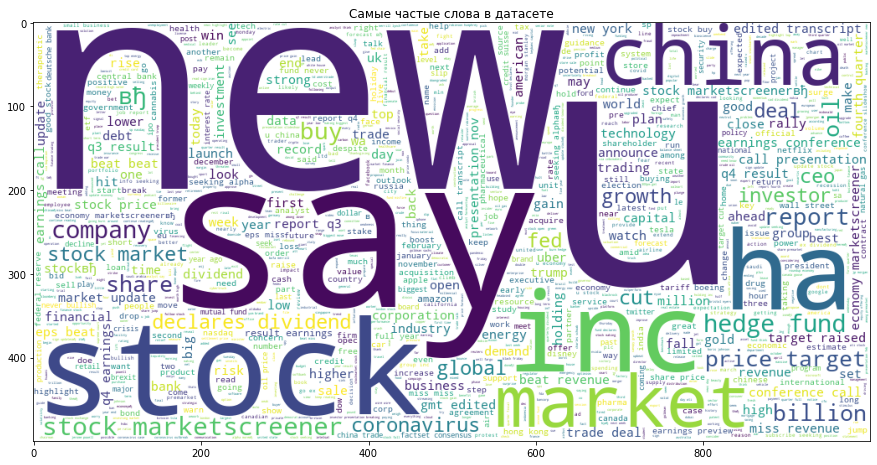

In [15]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=1000, height=500, random_state=42)
wordcloud.generate(" ".join(dataset_cleared_all["text"]))

plt.figure(figsize=(15,10))
plt.imshow(wordcloud)
plt.title("Самые частые слова в датасете")
plt.show()

### 2) Обучение моделей

In [16]:
def resample_data(dataset: pd.DataFrame) -> pd.DataFrame:
    vectorizer = CountVectorizer(min_df=5, max_df=0.5, max_features=15000)
    data_vectorizer = vectorizer.fit_transform(dataset["text"]).toarray()
    data_vectorizer_frame = pd.DataFrame(data=data_vectorizer)
    newdata = pd.concat([data_vectorizer_frame,  dataset['label']], axis=1)
    max_samples = newdata["label"].value_counts()[0]
    dataset_0 = newdata[newdata['label'] == newdata["label"].value_counts().index[0]]
    dataset_1 = newdata[newdata['label'] == newdata["label"].value_counts().index[1]]
    dataset_2 = newdata[newdata['label'] == newdata["label"].value_counts().index[2]]
    dataset_1 = resample(dataset_1, replace=True, n_samples=max_samples, random_state=42)
    dataset_2 = resample(dataset_2, replace=True, n_samples=max_samples, random_state=42)
    dataset_up_sample = pd.concat([dataset_0, dataset_1, dataset_2])
    return dataset_up_sample

In [17]:
dataset_cleared_http = resample_data(dataset_cleared_http)
dataset_cleared_punct = resample_data(dataset_cleared_punct)
dataset_cleared_stop_words = resample_data(dataset_cleared_stop_words)
dataset_cleared_all = resample_data(dataset_cleared_all)

In [18]:
dataset_cleared_all

,0,1,2,3,4,5,6,7,8,9,...,3163,3164,3165,3166,3167,3168,3169,3170,3171,label
358,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neutral
359,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neutral
360,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neutral
361,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neutral
362,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3271,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Bearish
6583,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Bearish
7636,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Bearish
7633,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Bearish


#### Модели

In [19]:
def Gaussian_NB(X_train, X_test, y_train, y_test):
    params_Gauss_NB = [{
    "priors": [None],
    "var_smoothing": [1e-9]
    }]

    Gauss_NB = GridSearchCV( # параметры GridSearchCV
    GaussianNB(),
    params_Gauss_NB,
    verbose = 1,
    cv=3,
    n_jobs=1,
    scoring="f1_macro"
    )

    Gauss_NB_res = Gauss_NB.fit(X_train, y_train) # подбираем лучшие параметры для оценщика
    Gauss_NB_pred = Gauss_NB_res.best_estimator_.predict(X_test) # предсказываем
    print(metrics.classification_report(y_test, Gauss_NB_pred))
    print(f"Лучший score={Gauss_NB_res.best_score_:.4f}")

In [20]:
def Multinomial_NB(X_train, X_test, y_train, y_test):
    params_Multinomial_NB = [{
    "alpha": [1.0],
    "force_alpha": [True],
    "fit_prior": [True],
    "class_prior": [None]
    }]

    Multinomial_NB = GridSearchCV( # параметры GridSearchCV
    MultinomialNB(),
    params_Multinomial_NB,
    verbose = 1,
    cv=3,
    n_jobs=1,
    scoring="f1_macro"
    )

    Multinomial_NB_res = Multinomial_NB.fit(X_train, y_train) # подбираем лучшие параметры для оценщика
    Multinomial_NB_pred = Multinomial_NB_res.best_estimator_.predict(X_test) # предсказываем
    print(metrics.classification_report(y_test, Multinomial_NB_pred))
    print(f"Лучший score={Multinomial_NB_res.best_score_:.4f}")

In [21]:
def Bernoulli_NB(X_train, X_test, y_train, y_test):
    params_Bernoulli_NB = [{
    "alpha": [1.0],
    "force_alpha": [True],
    "binarize": [0.0],
    "fit_prior": [True],
    "class_prior": [None]
    }]

    Bernoulli_NB = GridSearchCV( # параметры GridSearchCV
    BernoulliNB(),
    params_Bernoulli_NB,
    verbose = 1,
    cv=3,
    n_jobs=1,
    scoring="f1_macro"
    )

    Bernoulli_NB_res = Bernoulli_NB.fit(X_train, y_train) # подбираем лучшие параметры для оценщика
    Bernoulli_NB_pred = Bernoulli_NB_res.best_estimator_.predict(X_test) # предсказываем
    print(metrics.classification_report(y_test, Bernoulli_NB_pred))
    print(f"Лучший score={Bernoulli_NB_res.best_score_:.4f}")

In [22]:
def Complement_NB(X_train, X_test, y_train, y_test):
    params_Complement_NB = [{
    "alpha": [1.0],
    "force_alpha": [True],
    "fit_prior": [True],
    "class_prior": [None],
    "norm": [False]
    }]

    Complement_NB = GridSearchCV( # параметры GridSearchCV
    ComplementNB(),
    params_Complement_NB,
    verbose = 1,
    cv=3,
    n_jobs=1,
    scoring="f1_macro"
    )

    Complement_NB_res = Complement_NB.fit(X_train, y_train) # подбираем лучшие параметры для оценщика
    Complement_NB_pred = Complement_NB_res.best_estimator_.predict(X_test) # предсказываем
    print(metrics.classification_report(y_test, Complement_NB_pred))
    print(f"Лучший score={Complement_NB_res.best_score_:.4f}")

In [23]:
dataset_cleared_http

,0,1,2,3,4,5,6,7,8,9,...,3263,3264,3265,3266,3267,3268,3269,3270,3271,label
358,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neutral
359,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neutral
360,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neutral
361,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Neutral
362,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6584,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Bearish
7637,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Bearish
7634,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Bearish
9486,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Bearish


In [24]:
for i in [dataset_cleared_http, dataset_cleared_punct, dataset_cleared_stop_words, dataset_cleared_all]:
    Y = i['label'].values
    del i['label']
    X_train, X_test, y_train, y_test = train_test_split(i, Y, test_size=0.2, random_state=42)
    print('\n\nРассмотрим следующий вариант очистки текста:\n\n')
    print('\n\nGaussian_NB\n\n')
    Gaussian_NB(X_train, X_test, y_train, y_test)
    print('\n\nMultinomial_NB\n\n')
    Multinomial_NB(X_train, X_test, y_train, y_test)
    print('\n\nBernoulli_NB\n\n')
    Bernoulli_NB(X_train, X_test, y_train, y_test)
    print('\n\nComplement_NB\n\n')
    Complement_NB(X_train, X_test, y_train, y_test)



Рассмотрим следующий вариант очистки текста:




Gaussian_NB


Fitting 3 folds for each of 1 candidates, totalling 3 fits
              precision    recall  f1-score   support

     Bearish       0.58      0.95      0.72      1521
     Bullish       0.73      0.68      0.71      1542
     Neutral       0.98      0.44      0.61      1547

    accuracy                           0.69      4610
   macro avg       0.76      0.69      0.68      4610
weighted avg       0.77      0.69      0.68      4610

Лучший score=0.6933


Multinomial_NB


Fitting 3 folds for each of 1 candidates, totalling 3 fits
              precision    recall  f1-score   support

     Bearish       0.79      0.81      0.80      1521
     Bullish       0.81      0.82      0.81      1542
     Neutral       0.80      0.77      0.79      1547

    accuracy                           0.80      4610
   macro avg       0.80      0.80      0.80      4610
weighted avg       0.80      0.80      0.80      4610

Лучший score=0.7

### 3) Сравнение качества работы моделей

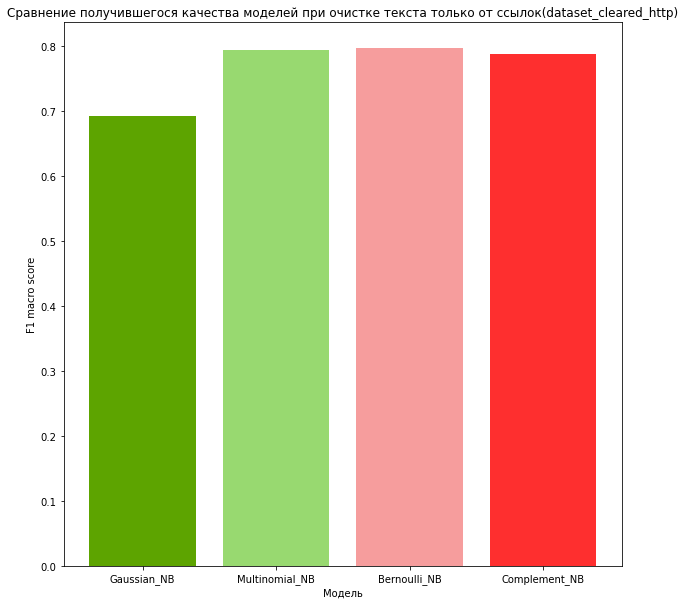

In [26]:
plt.figure(figsize=(10,10))
plt.bar(["Gaussian_NB", "Multinomial_NB", "Bernoulli_NB", "Complement_NB"], [0.6933, 0.7939, 0.7974, 0.7883], color=["#5da400", "#98d970", "#f69d9d", "#fe2f2f"])
plt.title('Сравнение получившегося качества моделей при очистке текста только от ссылок(dataset_cleared_http)')
plt.xlabel('Модель')
plt.ylabel('F1 macro score')
plt.show()

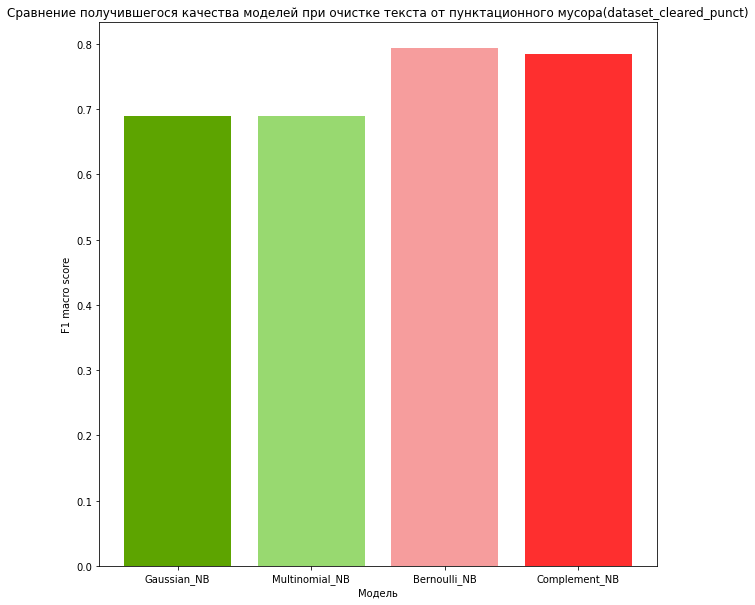

In [27]:
plt.figure(figsize=(10,10))
plt.bar(["Gaussian_NB", "Multinomial_NB", "Bernoulli_NB", "Complement_NB"], [0.6890, 0.6890, 0.7934, 0.7844], color=["#5da400", "#98d970", "#f69d9d", "#fe2f2f"])
plt.title('Сравнение получившегося качества моделей при очистке текста от пунктационного мусора(dataset_cleared_punct)')
plt.xlabel('Модель')
plt.ylabel('F1 macro score')
plt.show()

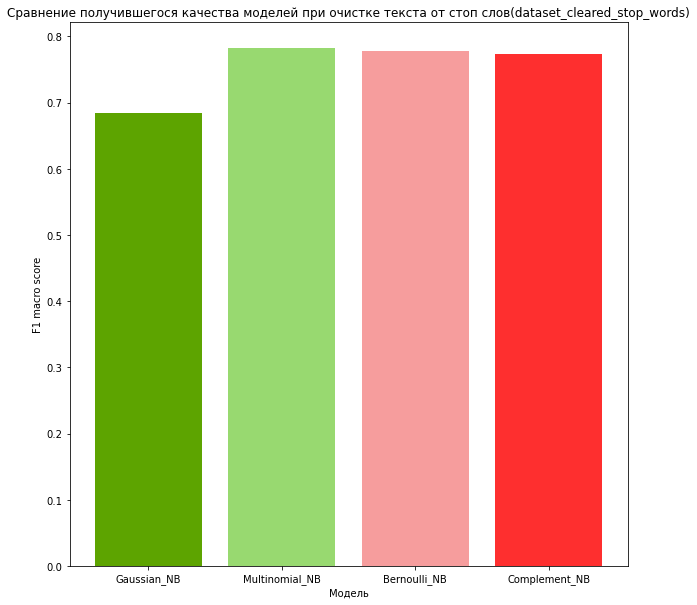

In [28]:
plt.figure(figsize=(10,10))
plt.bar(["Gaussian_NB", "Multinomial_NB", "Bernoulli_NB", "Complement_NB"], [0.6836, 0.7822, 0.7781, 0.7736], color=["#5da400", "#98d970", "#f69d9d", "#fe2f2f"])
plt.title('Сравнение получившегося качества моделей при очистке текста от стоп слов(dataset_cleared_stop_words)')
plt.xlabel('Модель')
plt.ylabel('F1 macro score')
plt.show()

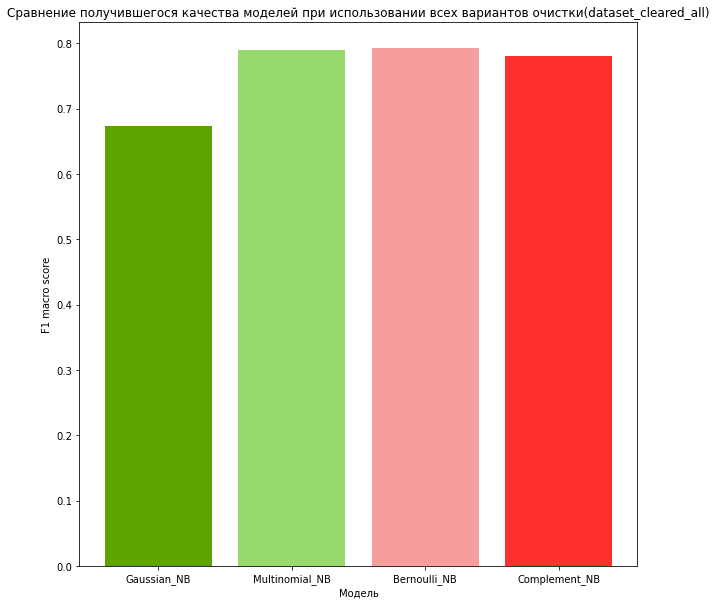

In [29]:
plt.figure(figsize=(10,10))
plt.bar(["Gaussian_NB", "Multinomial_NB", "Bernoulli_NB", "Complement_NB"], [0.6731, 0.7898, 0.7924, 0.7803], color=["#5da400", "#98d970", "#f69d9d", "#fe2f2f"])
plt.title('Сравнение получившегося качества моделей при использовании всех вариантов очистки(dataset_cleared_all)')
plt.xlabel('Модель')
plt.ylabel('F1 macro score')
plt.show()